## INTRODUCTION ##
This notebook is intended to built end to end text classification model using Transformer. Now , we know we have encoder and decoder in Transformers for each and every task we have specific architecture.
Following summarizes it:-

#    1. **Encoder** -->	ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa-->Sentence classification, named entity recognition, extractive question answering

#    2. **Decoder** --->GPT, GPT-2, Transformer XL-->Text generation

#    3. **Encoder-decoder** --->BART, T5, Marian, mBART--->Summarization, translation, generative question answering

#Since here we are going to do text classsification we need to use Encoder and variant of "Bert"

# Before starting we need to understand BERT Model. Look at the picture below:-
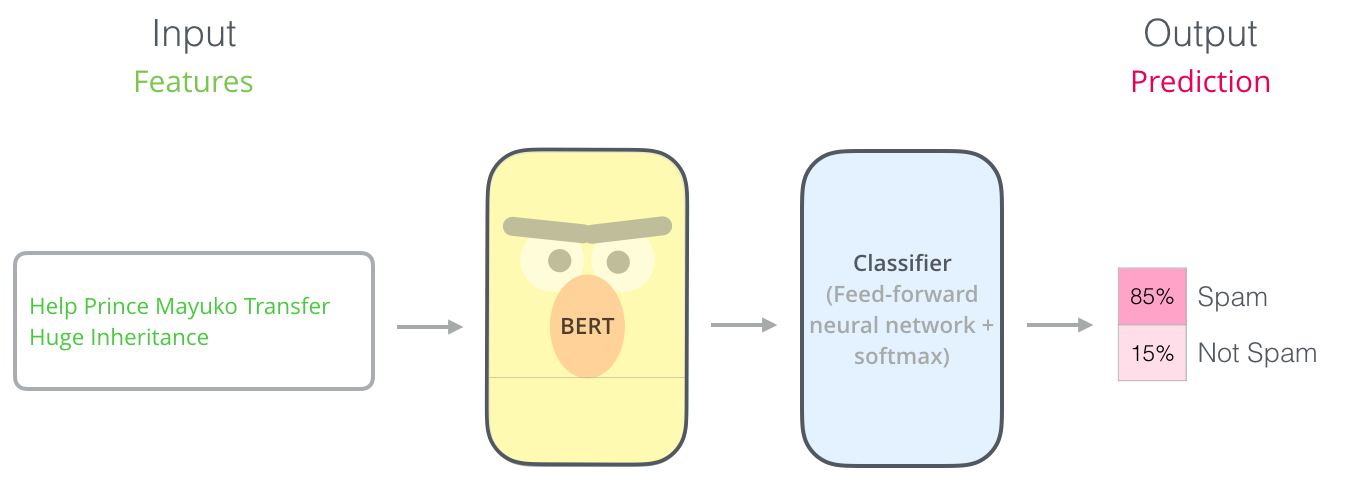
(source:-https://jalammar.github.io/illustrated-bert/)


In [1]:
!pip install transformers

In [2]:
!pip install datasets tensorflow

In [3]:
# Here I am using a pretrained dataset
from datasets import list_datasets

In [4]:
db=list_datasets()

<ipython-input-4-f3fd918b3e09>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  db=list_datasets()


In [5]:

# length of datasets
len(db)

61381

In [6]:
# loading emotion dataset
from datasets import load_dataset
df=load_dataset("emotion")

In [7]:
# look inside emotion dataset
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
# convert them to dataframe
import pandas as pd
data=pd.DataFrame(df['train'])

In [9]:
data

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [10]:
# getting the features of the train dataset
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [11]:
# adding label features in front of every label
def name(r):
  return df['train'].features["label"].int2str(r)
data['name']=data['label'].apply(name)

In [12]:
data

,text,label,name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


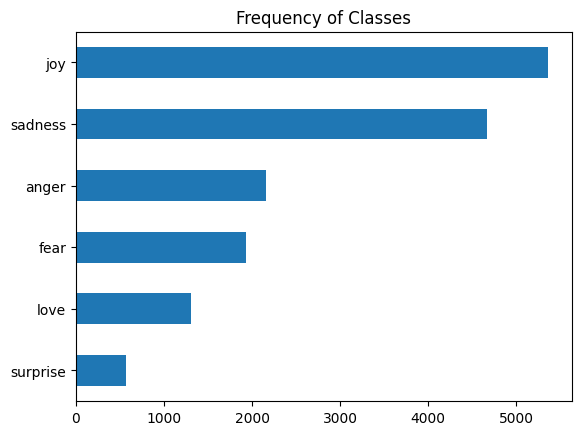

In [13]:
# some data analysis
import matplotlib.pyplot as plt
data['name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [14]:
data['no_of_words']=data['text'].str.split().apply(len)


In [15]:
data

,text,label,name,no_of_words
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


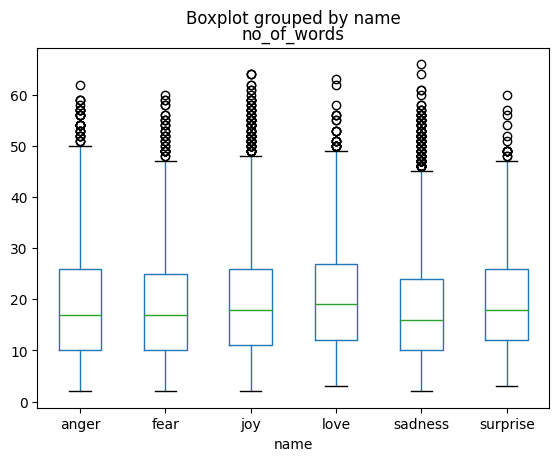

In [16]:
# getting the maximum length of tweets
data.boxplot("no_of_words",by="name",grid=False)
plt.show()

In [17]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Use the Bert Tansformer
Here I am going to use the DistilBERT. Some Points:-

    1) DistillBert can use 512 tokens or words at once.
    2) It has 786 features in Hidden state.

In [18]:
from transformers import BertTokenizer as bt
model="bert-base-uncased"
tokenizer=bt.from_pretrained(model)

In [19]:
encoded_text=tokenizer("I am living in Singapore.")
encoded_text

{'input_ids': [101, 1045, 2572, 2542, 1999, 5264, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

['[CLS]', 'i', 'am', 'living', 'in', 'singapore', '.', '[SEP]']

In [21]:
tokenizer.vocab_size

30522

In [22]:
tokenizer.model_max_length

512

In [23]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [24]:
#tokenize the whole dataset
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,truncation=True)


In [25]:
df_encoded=df.map(tokenize,batched=True,batch_size=None)

In [26]:
df_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [27]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:
# now passing this to encoder model
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [30]:
df_encoded.set_format("torch",columns=[ 'input_ids', 'token_type_ids', 'attention_mask','label'])

In [31]:
tokenizer.model_input_names


['input_ids', 'token_type_ids', 'attention_mask']

In [32]:
def extract_hidden_states(batch):
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    hidden_state=model(**inputs).last_hidden_state
  return {"hidden":hidden_state[:,0,:].cpu().numpy()}

In [33]:
df_hidden=df_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
df_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden'],
        num_rows: 2000
    })
})

In [35]:
df_hidden['train']['hidden'].size()

torch.Size([16000, 768])

In [36]:
df_hidden['train']['hidden'][0]

tensor([-8.8220e-02,  3.0442e-01, -2.3050e-01, -7.4142e-02, -5.5667e-01,
        -3.0746e-01,  2.7352e-01,  2.6367e-01,  2.3551e-01, -4.5742e-01,
         3.2873e-01, -6.5274e-02,  1.2680e-01, -2.6133e-02,  2.9723e-01,
        -9.6826e-03, -1.9268e-01,  5.4883e-01,  1.2471e-01,  1.2117e-02,
        -1.2091e-01, -7.2127e-01, -3.5150e-01, -7.7010e-02, -1.5284e-01,
        -2.0172e-01,  3.3001e-01, -2.2434e-01,  5.8223e-02, -3.3571e-01,
         3.6348e-02,  3.1582e-01, -5.5839e-01,  9.6847e-02,  2.4841e-01,
         4.9623e-02,  1.0558e-01,  1.4487e-01,  2.7895e-01,  5.5230e-02,
        -2.5206e-01, -2.8558e-01, -2.5508e-01, -7.6887e-02,  1.5792e-01,
        -3.1076e-01, -2.6166e+00,  5.2364e-02, -2.9073e-01, -2.1752e-01,
         3.2300e-01, -4.7254e-02, -9.0760e-03,  2.5618e-01, -2.1226e-01,
         5.4298e-01, -4.5251e-01,  5.2935e-01, -2.4736e-01,  3.3725e-01,
         5.1017e-01,  4.0209e-01, -4.0177e-01, -8.7595e-02,  1.2433e-01,
         2.8823e-01, -2.2749e-01,  6.5687e-01, -2.5

In [37]:
df_hidden['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [38]:
#create feature matrix
import numpy as np
x_train=np.array(df_hidden['train']['hidden'])
y_train=np.array(df_hidden['train']['label'])
x_valid=np.array(df_hidden['validation']['hidden'])
y_valid=np.array(df_hidden['validation']['label'])

In [39]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=3000)
lr.fit(x_train,y_train)

LogisticRegression(max_iter=3000)

In [40]:
lr.score(x_valid,y_valid)

0.595

In [41]:
from sklearn.dummy import DummyClassifier
d=DummyClassifier(strategy='most_frequent')
d.fit(x_train,y_train)
d.score(x_valid,y_valid)

0.352

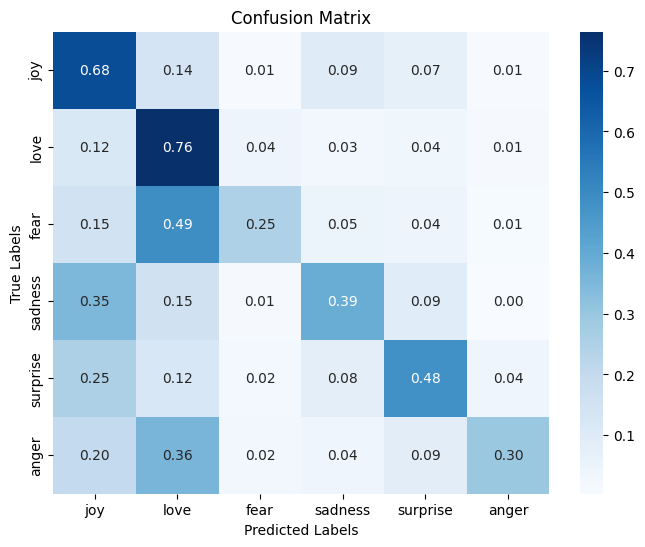

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_valid, lr.predict(x_valid),normalize="true")

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',xticklabels=set(df['train'].features['label'].names), yticklabels=set(df['train'].features['label'].names))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

FINE TUNING TRANSFORMER

In [43]:
from transformers import BertForSequenceClassification
model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
df_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [45]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [46]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [47]:
from sklearn.metrics import accuracy_score, f1_score
def computer_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

In [48]:
len(df_encoded['train'])//64

250

In [49]:
#!pip install transformers[torch]

In [50]:
#!pip install accelerate -U

In [51]:
from transformers import Trainer, TrainingArguments
batch_size=64
steps=len(df_encoded['train'])//batch_size
model_name="emotion"
train_args=TrainingArguments(output_dir="model_name",num_train_epochs=2,learning_rate=2e-5,
                             per_device_train_batch_size=batch_size,
                             per_device_eval_batch_size=batch_size,
                             weight_decay=0.01,
                             evaluation_strategy='epoch',
                             logging_steps=steps,
                             log_level='error')

In [54]:
trainer=Trainer(model=model,args=train_args,compute_metrics=computer_metrics,train_dataset=df_encoded['train'],eval_dataset=df_encoded['validation'],tokenizer=tokenizer)

In [55]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.798800,0.290767,0.907500,0.908169
2,0.211700,0.205663,0.924000,0.924248


TrainOutput(global_step=500, training_loss=0.5052523040771484, metrics={'train_runtime': 484.9565, 'train_samples_per_second': 65.985, 'train_steps_per_second': 1.031, 'total_flos': 1430717745024000.0, 'train_loss': 0.5052523040771484, 'epoch': 2.0})

In [56]:
preds_output=trainer.predict(df_encoded['validation'])

In [57]:
preds_output.metrics

{'test_loss': 0.20566271245479584,
 'test_accuracy': 0.924,
 'test_f1': 0.9242482523995091,
 'test_runtime': 8.4596,
 'test_samples_per_second': 236.418,
 'test_steps_per_second': 3.783}

In [58]:
y_preds=np.argmax(preds_output.predictions,axis=1)

In [66]:
y_preds

array([0, 0, 2, ..., 1, 2, 1])

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_preds, y_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

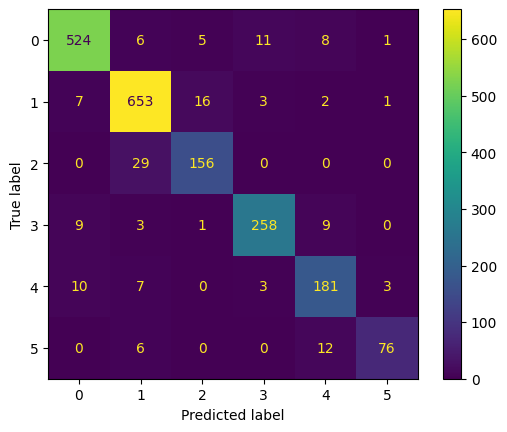

In [67]:
disp.plot()

#Error Analysis

In [68]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output=model(**inputs)
    pred_label=torch.argmax(output.logits,axis=-1)
    loss=cross_entropy(output.logits,batch["label"].to(device),reduction="none")
    return{"loss":loss.cpu().numpy(),
           "predicted":pred_label.cpu().numpy()}

In [69]:
df_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])
df_encoded["validation"]=df_encoded['validation'].map(forward_pass_with_label,batched=True,batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [70]:
df_encoded["validation"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'loss', 'predicted'],
    num_rows: 2000
})

In [71]:
df_encoded.set_format("pandas")
cols=['text', 'label', 'loss', 'predicted']
df_test=df_encoded['validation'][:][cols]
df_test["label"]=df_test["label"].apply(name)
df_test["predicted"]=df_test["predicted"].apply(name)


In [72]:
df_test

,text,label,loss,predicted
0,im feeling quite sad and sorry for myself but ...,sadness,0.014877,sadness
1,i feel like i am still looking at a blank canv...,sadness,0.013028,sadness
2,i feel like a faithful servant,love,0.368684,love
3,i am just feeling cranky and blue,anger,0.021490,anger
4,i can have for a treat or if i am feeling festive,joy,0.020418,joy
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,0.011926,sadness
1996,i constantly worry about their fight against n...,joy,0.024328,joy
1997,i feel its important to share this info for th...,joy,0.024443,joy
1998,i truly feel that if you are passionate enough...,joy,0.757921,love


In [73]:
df_test.sort_values("loss",ascending=False)

,text,label,loss,predicted
1801,i feel that he was being overshadowed by the s...,love,5.930360,sadness
1963,i called myself pro life and voted for perry w...,joy,5.907793,sadness
1950,i as representative of everything thats wrong ...,surprise,5.614007,sadness
882,i feel badly about reneging on my commitment t...,love,5.192224,sadness
1683,i had applied for a job and they had assured m...,anger,5.156768,joy
...,...,...,...,...
1601,i feel so ungrateful when thinking saying thes...,sadness,0.010110,sadness
394,i feel shamed that i hoped for one last christ...,sadness,0.010110,sadness
34,i feel that i m so pathetic and downright dumb...,sadness,0.010087,sadness
69,i have no extra money im worried all of the ti...,sadness,0.010026,sadness
